# MiniProject 2: Training and Evaluation Practices

- Leo Thomasson (#261167871) 
- Ella Lukasiewicz (#261169106)
- Eve Rabin (#261160750)


In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

## 0.1 Loading the dataset

In [49]:
df = pd.read_csv("spambase/spambase.data", header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


### Inspecting the dataset

There are 57 features and 1 Class (our target). All 57 features are continuous, while our Class is Binary. This represents the variable we are trying to predict from all of the features (1 for spam or 0 for not spam). Of the 57 features :

- 55 features of type **float**
    - 48 represent word frequencies (word_freq_...)
    - 6 represent char frequencies (char_freq_.)
    - 1 represents capital_run_length_average
- 2 features of type **int**
    - capital_run_length_longest, and capital_run_length_total

In [50]:
# get feature names
df_names = pd.read_csv(
    "spambase/spambase.names",
    header=None,
    comment="|",      # ignore comment lines
    skip_blank_lines=True
)

# Keep only lines that define features (contain :)
df_names = df_names[df_names[0].str.contains(":")]

# Extract feature names (text before :)
feature_names = df_names[0].str.split(":", expand=True)[0].tolist()

df.columns = feature_names + ["Class"]
df.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,Class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


## 0.2 Cleaning data

In [64]:
#check for missing values or placeholders
df.info(verbose=True, show_counts=True)
assert not df.isna().any().any(), "Dataset contains missing (NaN) values"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_report            4601 

Therefore we have no missing data, there are no NaN values in all 4601 entries. 

## 0.2 Standardization


### a) Check Standardization
Next, in order to accurately use SGD, we need to determine if the features in our dataset have been standardized.

In [67]:
# Mean of each feature
feature_means = df.mean()

# Variance of each feature (population variance)
feature_variances = df.var(ddof=0)

# Combine into a single DataFrame for easy inspection
stats = pd.DataFrame({
    "mean": feature_means,
    "variance": feature_variances
})

print(stats)

                                  mean       variance
word_freq_make                0.104553       0.093223
word_freq_address             0.213015       1.665222
word_freq_all                 0.280656       0.254105
word_freq_3d                  0.065425       1.946024
word_freq_our                 0.312223       0.452175
word_freq_over                0.095901       0.074963
word_freq_remove              0.114208       0.153193
word_freq_internet            0.105295       0.160823
word_freq_order               0.090067       0.077610
word_freq_mail                0.239413       0.415619
word_freq_receive             0.059824       0.040611
word_freq_will                0.541702       0.742363
word_freq_people              0.093930       0.090603
word_freq_report              0.058626       0.112324
word_freq_addresses           0.049205       0.066985
word_freq_free                0.248848       0.681784
word_freq_business            0.142586       0.197142
word_freq_email             

Clearly, the features have not been standardized. No means = 0 and no STDs = 1

### b) Standardize all features in our DataFrame

We will standardize later, only on the training set in order to avoid leakage. 
Go to **1.2 a)**.  

We first look to standardize X_train, adn then standardize X_test with the mean and std found int the training data, so that our SGD regression model can accurately work on the test data.



## 0.3 Correlation visualization

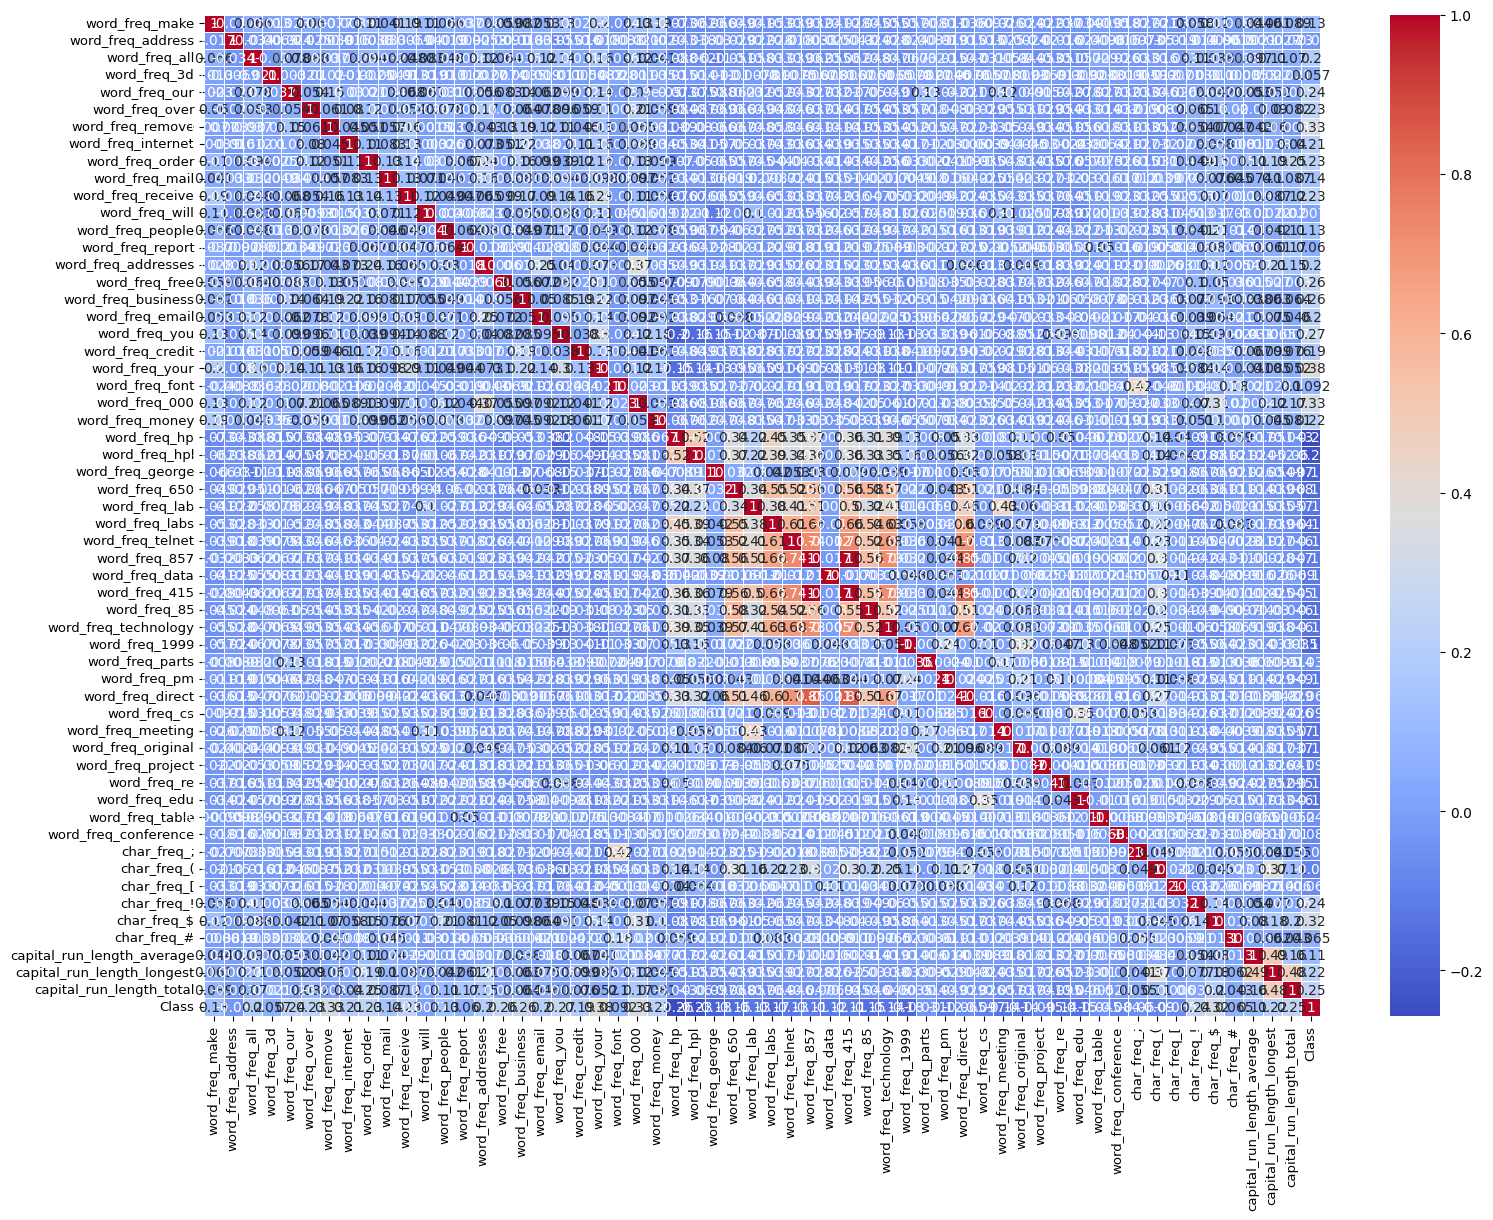

In [77]:
#correlation Matrix to better understand releationships between features
plt.figure(figsize=(18,13))
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, linewidths=.5, cmap='coolwarm', annot=True)
plt.xticks(fontsize=9.5)
plt.yticks(fontsize=9.5)
plt.show()

 This correlation matrix allows to visualize strongly connected features. As we go on with the assignment, we can more accurately understand the effects of L2 regualarization by looking back at this matrix.

## **Task 1: Logistic Regression with SGD**

First, we can seperate with a 95/5% test/train split all samples in the dataset. 

In [ ]:
def train_test_split_5_95(X, y, seed=2026):
    rng = np.random.default_rng(seed)
    n_samples = X.shape[0]

    # Shuffle indices
    indices = rng.permutation(n_samples)

    # Compute split index (5% train)
    n_train = int(0.05 * n_samples)

    train_idx = indices[:n_train]
    test_idx  = indices[n_train:]

    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test  = X[test_idx]
    y_test  = y[test_idx]

    return X_train, y_train, X_test, y_test

## 1.1 Implementation of Logistic Regression with SGD 

We use L_reg(w,b) = L(w,b) + 𝜆/2 (||w||^2)2, so the L2 gradient contribution is 𝜆w.

In [83]:
class LogisticRegressionSGD:
    """
    Mini-batch SGD logistic regression with L2 regularization (weight decay).
    - Binary labels y in {0,1}
    - Uses a separate bias term b (not regularized by default)
    """

    def __init__(
        self,
        lr=0.1,
        epochs=100,
        batch_size=32,
        l2=0.0,
        seed=2026,
        fit_intercept=True,
        reg_bias=False,   # usually False (don't regularize bias)
        verbose=False
    ):
        self.lr = float(lr)
        self.epochs = int(epochs)
        self.batch_size = int(batch_size)
        self.l2 = float(l2)
        self.fit_intercept = bool(fit_intercept)
        self.reg_bias = bool(reg_bias)
        self.verbose = bool(verbose)

        self.rng = np.random.default_rng(seed)

        # Learned parameters
        self.w = None
        self.b = 0.0

        # Training history
        self.history_ = {
            "loss": [],
            "acc": [],
            "w_norm": []
        }

    @staticmethod
    def _sigmoid(z):
        # Numerically stable sigmoid
        z = np.clip(z, -50, 50)
        return 1.0 / (1.0 + np.exp(-z))

    @staticmethod
    def _binary_accuracy(y_true, y_pred01):
        return float(np.mean(y_true == y_pred01))

    def _loss(self, X, y):
        """
        Average logistic loss + (l2/2)*||w||^2.
        """
        p = self.predict_proba(X)
        eps = 1e-15
        p = np.clip(p, eps, 1 - eps)

        # Cross-entropy
        ce = -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

        # L2 penalty (bias excluded unless reg_bias=True)
        if self.w is None:
            return ce

        reg = 0.5 * self.l2 * np.sum(self.w ** 2)
        if self.fit_intercept and self.reg_bias:
            reg += 0.5 * self.l2 * (self.b ** 2)

        return ce + reg

    def predict_proba(self, X):
        X = np.asarray(X, dtype=float)
        if self.w is None:
            raise RuntimeError("Model is not fitted yet. Call fit() first.")

        z = X @ self.w
        if self.fit_intercept:
            z = z + self.b
        return self._sigmoid(z)

    def predict(self, X, threshold=0.5):
        p = self.predict_proba(X)
        return (p >= threshold).astype(int)

    def fit(self, X, y, X_val=None, y_val=None):
        """
        Train using mini-batch SGD.
        Optionally track validation metrics if X_val/y_val provided.
        """
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=int)

        if set(np.unique(y)) - {0, 1}:
            raise ValueError("y must be binary with values in {0,1}.")

        n, d = X.shape
        if self.batch_size <= 0:
            raise ValueError("batch_size must be positive.")

        # Initialize weights
        self.w = np.zeros(d, dtype=float)
        self.b = 0.0

        for epoch in range(self.epochs):
            # Shuffle training data each epoch
            idx = self.rng.permutation(n)

            for start in range(0, n, self.batch_size):
                batch_idx = idx[start:start + self.batch_size]
                Xb = X[batch_idx]
                yb = y[batch_idx]
                m = Xb.shape[0]

                # Forward
                z = Xb @ self.w
                if self.fit_intercept:
                    z = z + self.b
                p = self._sigmoid(z)

                # Gradients of average cross-entropy
                # e = p - y
                e = (p - yb)

                grad_w = (Xb.T @ e) / m
                grad_b = float(np.mean(e)) if self.fit_intercept else 0.0

                # Add L2 gradients (weight decay)
                grad_w += self.l2 * self.w
                if self.fit_intercept and self.reg_bias:
                    grad_b += self.l2 * self.b

                # SGD update
                self.w -= self.lr * grad_w
                if self.fit_intercept:
                    self.b -= self.lr * grad_b

            # Track training metrics each epoch
            train_loss = self._loss(X, y)
            train_pred = self.predict(X)
            train_p = self.predict_proba(X)
            train_ce = -np.mean(y*np.log(np.clip(train_p,1e-15,1-1e-15)) + (1-y)*np.log(np.clip(1-train_p,1e-15,1-1e-15)))
            self.history_.setdefault("ce", []).append(float(train_ce))
            train_acc = self._binary_accuracy(y, train_pred)
            w_norm = float(np.linalg.norm(self.w))

            self.history_["loss"].append(train_loss)
            self.history_["acc"].append(train_acc)
            self.history_["w_norm"].append(w_norm)

            if self.verbose:
                msg = f"Epoch {epoch+1:03d}/{self.epochs} | loss={train_loss:.4f} acc={train_acc:.4f} ||w||={w_norm:.3f}"
                if X_val is not None and y_val is not None:
                    val_loss = self._loss(X_val, y_val)
                    val_acc = self._binary_accuracy(y_val, self.predict(X_val))
                    msg += f" | val_loss={val_loss:.4f} val_acc={val_acc:.4f}"
                print(msg)

        return self

## 1.2 Deliverables for Task 1

### a) Initializing all variables & standardize training data

In [95]:
# Separate features and label
X = df.drop(columns=["Class"]).values
y = df["Class"]

X_train, y_train, X_test, y_test = train_test_split_5_95(X, y, seed=2026)

# STANDARDIZE
# Fit scaler ONLY on training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Apply same transformation to test data
X_test = scaler.transform(X_test)


# X_train, y_train already split + standardized (important!)
model = LogisticRegressionSGD(lr=0.1, epochs=200, batch_size=32, l2=1e-3, verbose=True)
model.fit(X_train, y_train)

# Retrieve Class proportions
class_proportions = np.bincount(y) / len(y)


test_pred = model.predict(X_test)
test_acc = (test_pred == y_test).mean()
print("Test accuracy:", test_acc)
print(class_proportions)


Epoch 001/200 | loss=0.4360 acc=0.9217 ||w||=0.473
Epoch 002/200 | loss=0.3571 acc=0.9304 ||w||=0.713
Epoch 003/200 | loss=0.3150 acc=0.9391 ||w||=0.884
Epoch 004/200 | loss=0.2877 acc=0.9435 ||w||=1.024
Epoch 005/200 | loss=0.2690 acc=0.9391 ||w||=1.131
Epoch 006/200 | loss=0.2529 acc=0.9391 ||w||=1.235
Epoch 007/200 | loss=0.2396 acc=0.9435 ||w||=1.325
Epoch 008/200 | loss=0.2293 acc=0.9435 ||w||=1.407
Epoch 009/200 | loss=0.2204 acc=0.9435 ||w||=1.485
Epoch 010/200 | loss=0.2136 acc=0.9435 ||w||=1.550
Epoch 011/200 | loss=0.2070 acc=0.9435 ||w||=1.620
Epoch 012/200 | loss=0.2009 acc=0.9478 ||w||=1.682
Epoch 013/200 | loss=0.1953 acc=0.9478 ||w||=1.742
Epoch 014/200 | loss=0.1901 acc=0.9522 ||w||=1.803
Epoch 015/200 | loss=0.1858 acc=0.9478 ||w||=1.857
Epoch 016/200 | loss=0.1817 acc=0.9522 ||w||=1.912
Epoch 017/200 | loss=0.1786 acc=0.9522 ||w||=1.962
Epoch 018/200 | loss=0.1747 acc=0.9522 ||w||=2.012
Epoch 019/200 | loss=0.1718 acc=0.9478 ||w||=2.055
Epoch 020/200 | loss=0.1687 acc

With a small training set (≈230 samples), SGD exhibits high variance and unstable optimization when the learning rate is too large. We observe oscillating training loss, accuracy close to class proportions, and an increasing weight norm, indicating that updates overshoot the optimum. This motivates careful tuning of the learning rate and regularization strength. With 200 epochs we recorded large discrepencies such as :
- ||w|| (weight norm): exploding from ~7 to ~82
- acc: is roughly following Class proportions, Class = 0 has a freq of ~0.61 and Class = 1 ~0.39
- loss: very large, and does not decrease over the epochs
- and a low test accuracy of ~0.43

It's important to keep in mind that this is for the following parameters: lr=0.1, epochs=200, batch_size=32, l2=1e-3

NOW, lets use recommended hyperparameters, and compare between

In [96]:
# Hyperparameters to test (as provided)
lr_params = [1, 1e-1, 1e-2, 1e-3, 1e-4]
batch_size_params = [1, 16, 64]
epochs_list = [50, 100, 150, 200]
l2_values = [0.0, 1e-3]  # No regularization and L2 with fixed lambda=1e-3

# Fixed defaults for varying one parameter at a time
default_epochs = 150
default_batch_size = 32
default_lr = 0.01  # 1e-2, as suggested for initial
default_l2 = 0.0

# Dictionary to store results for plotting
results = {
    'lr': {'models_no_reg': {}, 'models_reg': {}, 'epochs': default_epochs, 'batch_size': default_batch_size},
    'batch_size': {'models_no_reg': {}, 'models_reg': {}, 'epochs': default_epochs, 'lr': default_lr},
    'epochs': {'models_no_reg': {}, 'models_reg': {}, 'lr': default_lr, 'batch_size': default_batch_size},
    'l2_comparison': {'models': {}, 'lr': default_lr, 'epochs': default_epochs, 'batch_size': default_batch_size}
}


### b) Training of models (varying 1 hyperparameter at a time)

In [99]:
print("Training models by varying hyperparameters one at a time...\n")

# 1. Vary learning rate (lr), fixed: epochs=100, batch_size=32, l2=0 or 1e-3
print("Varying learning rate:")
for lr in lr_params:
    for l2_val, reg_label in zip(l2_values, ['no_reg', 'reg']):
        model = LogisticRegressionSGD(lr=lr, epochs=default_epochs, batch_size=default_batch_size, l2=l2_val, seed=2026, verbose=False)
        model.fit(X_train, y_train)
        
        key = f"lr_{lr}"
        if reg_label == 'no_reg':
            results['lr']['models_no_reg'][key] = model
        else:
            results['lr']['models_reg'][key] = model

# 2. Vary batch size, fixed: epochs=100, lr=0.01, l2=0 or 1e-3
print("\nVarying batch size:")
for bs in batch_size_params:
    for l2_val, reg_label in zip(l2_values, ['no_reg', 'reg']):
        model = LogisticRegressionSGD(lr=default_lr, epochs=default_epochs, batch_size=bs, l2=l2_val, seed=2026, verbose=False)
        model.fit(X_train, y_train)
        
        key = f"bs_{bs}"
        if reg_label == 'no_reg':
            results['batch_size']['models_no_reg'][key] = model
        else:
            results['batch_size']['models_reg'][key] = model

# 3. Vary epochs, fixed: lr=0.01, batch_size=32, l2=0 or 1e-3
print("\nVarying epochs:")
for eps in epochs_list:
    for l2_val, reg_label in zip(l2_values, ['no_reg', 'reg']):
        model = LogisticRegressionSGD(lr=default_lr, epochs=eps, batch_size=default_batch_size, l2=l2_val, seed=2026, verbose=False)
        model.fit(X_train, y_train)
        
        key = f"epochs_{eps}"
        if reg_label == 'no_reg':
            results['epochs']['models_no_reg'][key] = model
        else:
            results['epochs']['models_reg'][key] = model

# 4. Special comparison: no reg vs L2=1e-3, fixed other params
print("\nTraining for L2 comparison (fixed params):")
for l2_val, reg_label in zip(l2_values, ['no_reg', 'l2']):
    model = LogisticRegressionSGD(lr=default_lr, epochs=default_epochs, batch_size=default_batch_size, l2=l2_val, seed=2026, verbose=True)
    model.fit(X_train, y_train)
    results['l2_comparison']['models'][reg_label] = model



Training models by varying hyperparameters one at a time...

Varying learning rate:

Varying batch size:

Varying epochs:

Training for L2 comparison (fixed params):
Epoch 001/150 | loss=0.6453 acc=0.9174 ||w||=0.066
Epoch 002/150 | loss=0.6074 acc=0.9261 ||w||=0.120
Epoch 003/150 | loss=0.5746 acc=0.9217 ||w||=0.172
Epoch 004/150 | loss=0.5476 acc=0.9304 ||w||=0.219
Epoch 005/150 | loss=0.5261 acc=0.9261 ||w||=0.259
Epoch 006/150 | loss=0.5064 acc=0.9261 ||w||=0.298
Epoch 007/150 | loss=0.4890 acc=0.9304 ||w||=0.334
Epoch 008/150 | loss=0.4734 acc=0.9304 ||w||=0.368
Epoch 009/150 | loss=0.4598 acc=0.9304 ||w||=0.399
Epoch 010/150 | loss=0.4473 acc=0.9348 ||w||=0.430
Epoch 011/150 | loss=0.4359 acc=0.9348 ||w||=0.459
Epoch 012/150 | loss=0.4249 acc=0.9348 ||w||=0.487
Epoch 013/150 | loss=0.4150 acc=0.9348 ||w||=0.514
Epoch 014/150 | loss=0.4061 acc=0.9348 ||w||=0.539
Epoch 015/150 | loss=0.3978 acc=0.9348 ||w||=0.564
Epoch 016/150 | loss=0.3901 acc=0.9348 ||w||=0.588
Epoch 017/150 | lo

### c) Plot deliverables

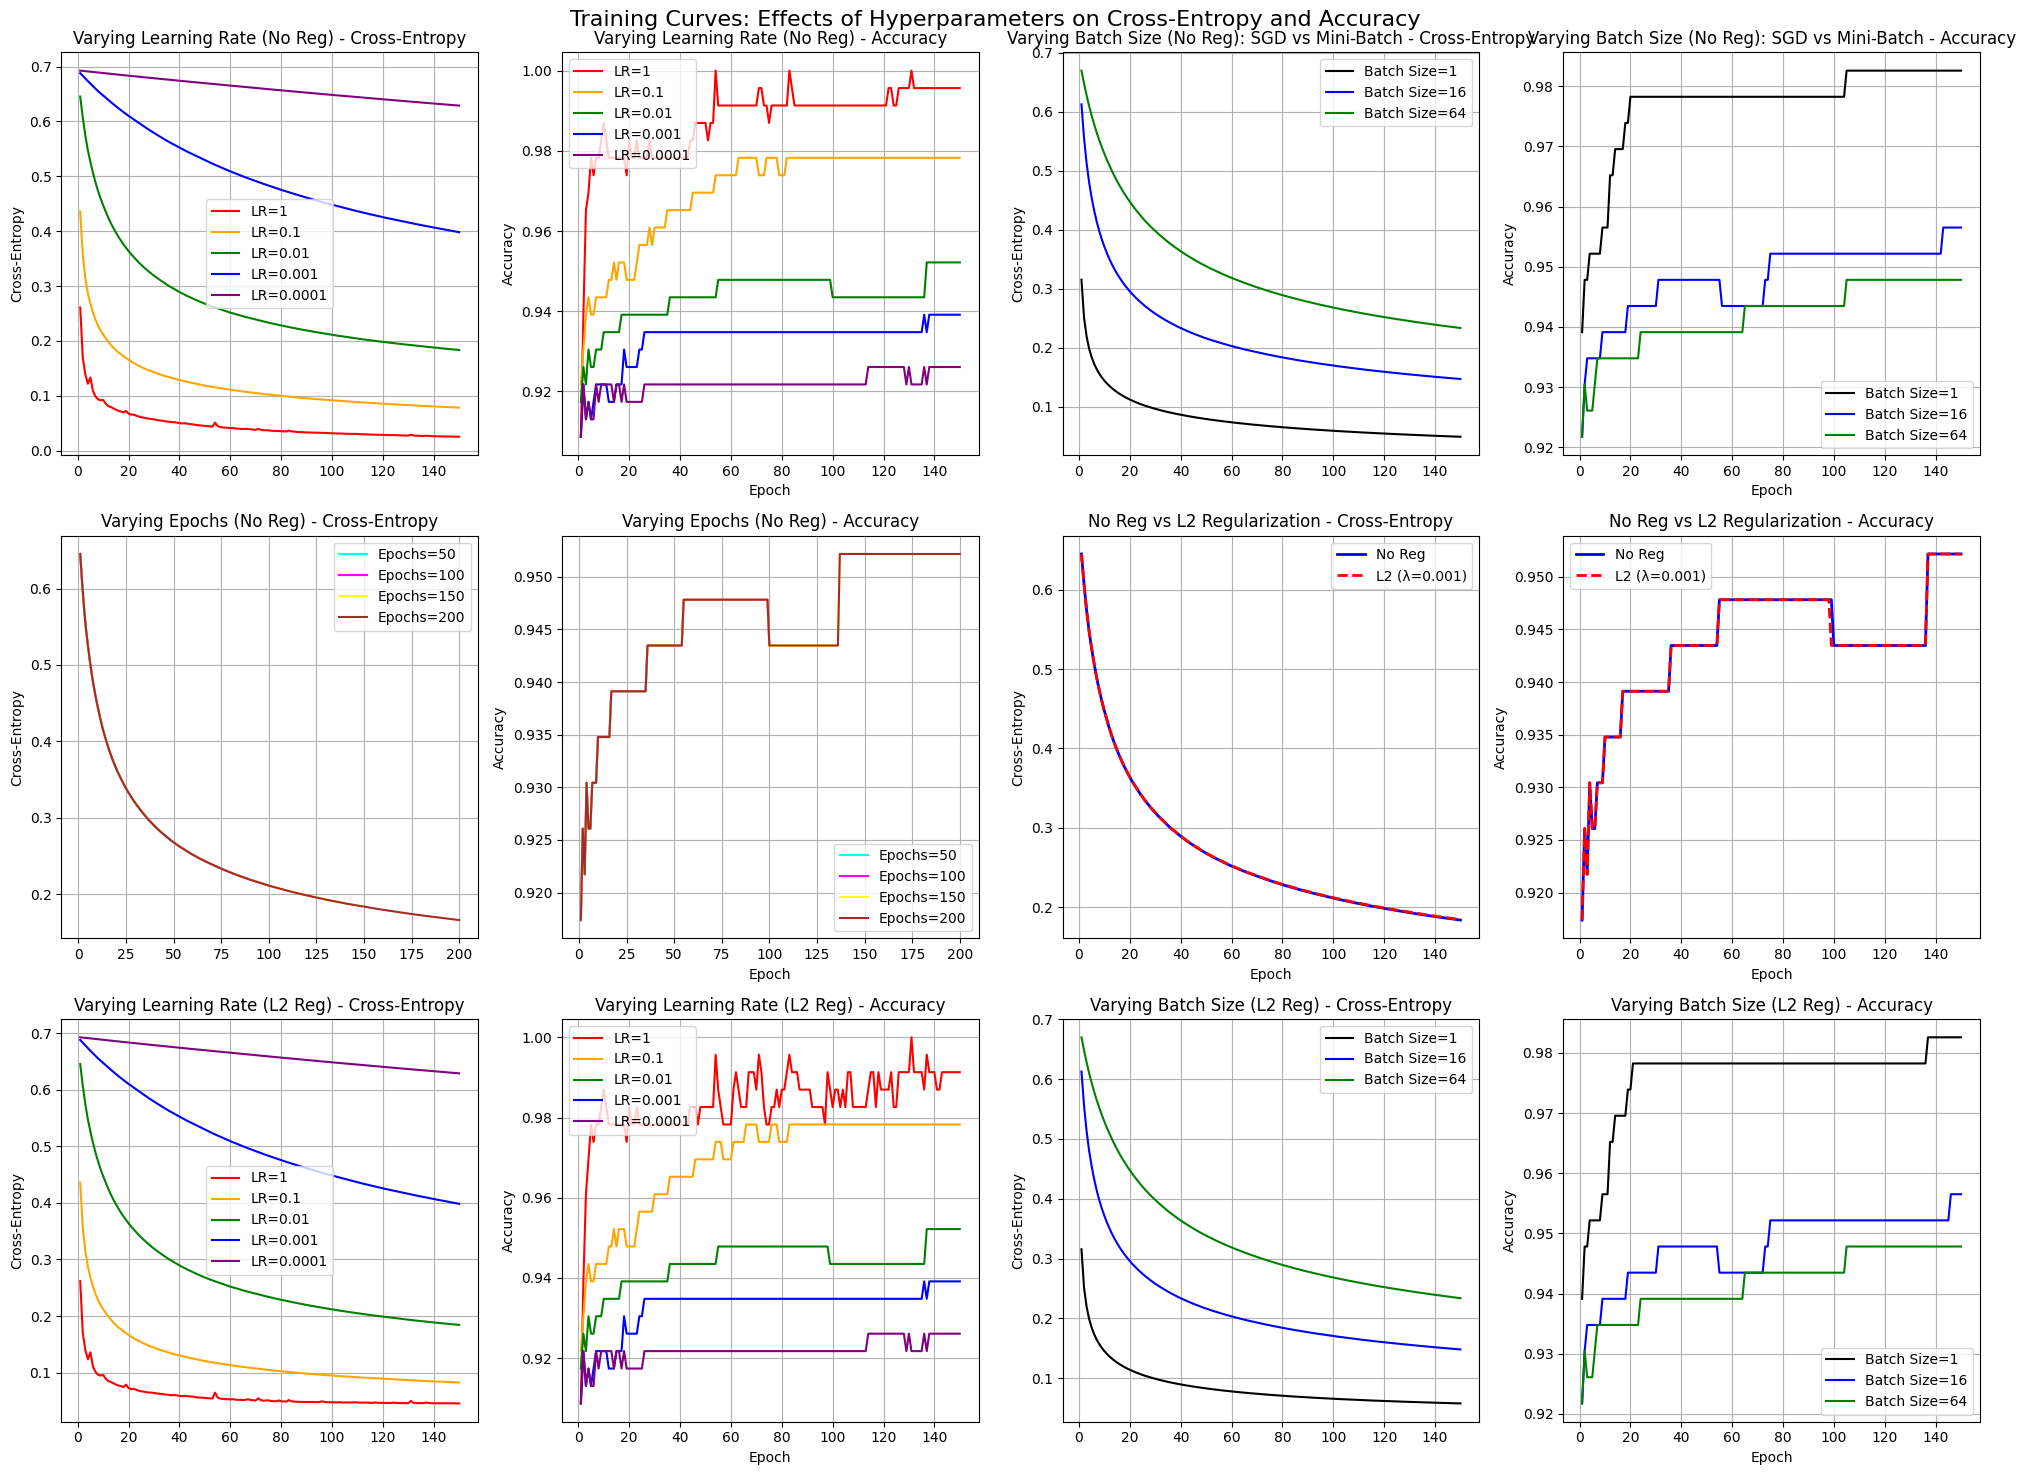

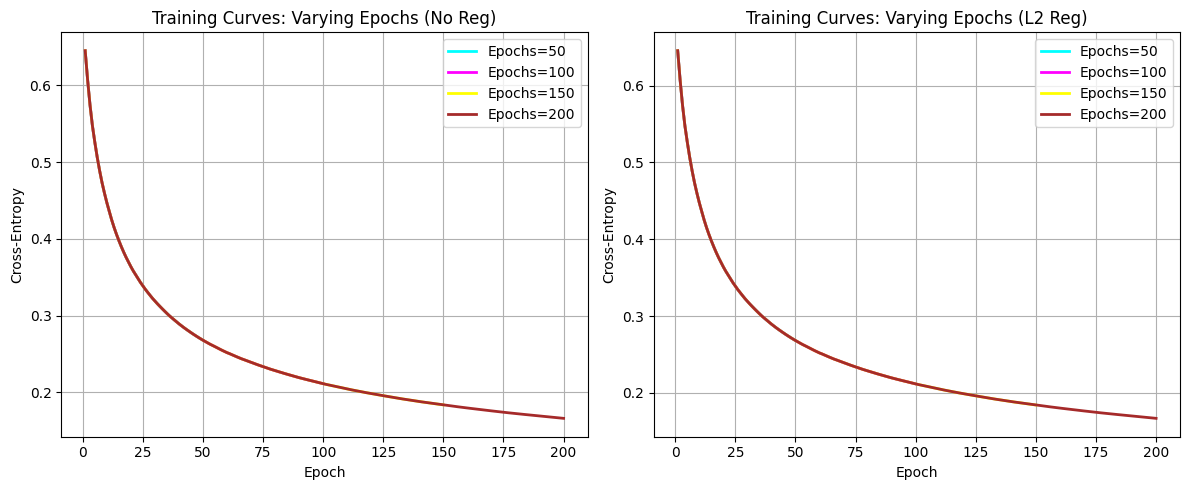


Test Accuracy for recommended params (lr=0.01, bs=32, epochs=100, λ=1e-3): 0.9021


In [103]:
# Fixed helper function to handle different epoch lengths
def plot_curves_fixed_epochs(ax, models_dict, param_name, title, color_map=None):
    """Plot curves for models with SAME number of epochs (fixed epochs)"""
    # All models should have same epoch length for this function
    epochs_range = range(1, len(next(iter(models_dict.values())).history_['ce']) + 1)
    
    for i, (key, model) in enumerate(models_dict.items()):
        ce = model.history_['ce']
        acc = model.history_['acc']
        label = f"{param_name}={key.split('_')[1]}"
        color = color_map[i] if color_map else None
        
        ax[0].plot(epochs_range, ce, label=label, color=color)
        ax[1].plot(epochs_range, acc, label=label, color=color)
    
    ax[0].set_ylabel('Cross-Entropy')
    ax[0].set_title(f'{title} - Cross-Entropy')
    ax[0].legend()
    ax[0].grid(True)
    
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_title(f'{title} - Accuracy')
    ax[1].legend()
    ax[1].grid(True)

def plot_curves_varying_epochs(ax, models_dict, param_name, title, color_map=None):
    """Plot curves for models with DIFFERENT number of epochs (varying epochs)"""
    for i, (key, model) in enumerate(models_dict.items()):
        epochs_num = int(key.split('_')[1])  # Extract epoch number from key
        epochs_range = range(1, epochs_num + 1)
        ce = model.history_['ce']
        acc = model.history_['acc']
        label = f"{param_name}={epochs_num}"
        color = color_map[i] if color_map else None
        
        ax[0].plot(epochs_range, ce, label=label, color=color)
        ax[1].plot(epochs_range, acc, label=label, color=color)
    
    ax[0].set_ylabel('Cross-Entropy')
    ax[0].set_title(f'{title} - Cross-Entropy')
    ax[0].legend()
    ax[0].grid(True)
    
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_title(f'{title} - Accuracy')
    ax[1].legend()
    ax[1].grid(True)

# Create visualization
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('Training Curves: Effects of Hyperparameters on Cross-Entropy and Accuracy', fontsize=16)

# Plot 1: Varying LR (no reg)
plot_curves_fixed_epochs(axes[0, :2], results['lr']['models_no_reg'], 'LR', 'Varying Learning Rate (No Reg)', 
                        color_map=['red', 'orange', 'green', 'blue', 'purple'])

# Plot 2: Varying Batch Size (no reg) - Highlight SGD (bs=1) vs mini-batch
plot_curves_fixed_epochs(axes[0, 2:], results['batch_size']['models_no_reg'], 'Batch Size', 'Varying Batch Size (No Reg): SGD vs Mini-Batch', 
                        color_map=['black', 'blue', 'green'])

# Plot 3: Varying Epochs (no reg) - Use special function for varying epochs
plot_curves_varying_epochs(axes[1, :2], results['epochs']['models_no_reg'], 'Epochs', 'Varying Epochs (No Reg)', 
                          color_map=['cyan', 'magenta', 'yellow', 'brown'])

# Plot 4: L2 Comparison (no reg vs reg) - Fixed params
ax_l2_ce = axes[1, 2]
ax_l2_acc = axes[1, 3]

epochs_range = range(1, default_epochs + 1)
for reg_label, model in results['l2_comparison']['models'].items():
    ce = model.history_['ce']
    acc = model.history_['acc']
    color = 'blue' if reg_label == 'no_reg' else 'red'
    style = '-' if reg_label == 'no_reg' else '--'
    label = f'No Reg' if reg_label == 'no_reg' else f'L2 (λ={model.l2})'
    
    ax_l2_ce.plot(epochs_range, ce, label=label, color=color, linestyle=style, linewidth=2)
    ax_l2_acc.plot(epochs_range, acc, label=label, color=color, linestyle=style, linewidth=2)

ax_l2_ce.set_title('No Reg vs L2 Regularization - Cross-Entropy')
ax_l2_ce.set_xlabel('Epoch')
ax_l2_ce.set_ylabel('Cross-Entropy')
ax_l2_ce.legend()
ax_l2_ce.grid(True)

ax_l2_acc.set_title('No Reg vs L2 Regularization - Accuracy')
ax_l2_acc.set_xlabel('Epoch')
ax_l2_acc.set_ylabel('Accuracy')
ax_l2_acc.legend()
ax_l2_acc.grid(True)

# Plot 5 & 6: Same comparisons but with L2 regularization
plot_curves_fixed_epochs(axes[2, :2], results['lr']['models_reg'], 'LR', 'Varying Learning Rate (L2 Reg)', 
                        color_map=['red', 'orange', 'green', 'blue', 'purple'])

plot_curves_fixed_epochs(axes[2, 2:], results['batch_size']['models_reg'], 'Batch Size', 'Varying Batch Size (L2 Reg)', 
                        color_map=['black', 'blue', 'green'])

plt.tight_layout()
plt.show()

# Additional separate plot for epoch comparison with better visibility
fig2, ax2 = plt.subplots(1, 2, figsize=(12, 5))

# No regularization
for i, (key, model) in enumerate(results['epochs']['models_no_reg'].items()):
    epochs_num = int(key.split('_')[1])
    epochs_range = range(1, epochs_num + 1)
    ce = model.history_['ce']
    color_map = ['cyan', 'magenta', 'yellow', 'brown']
    ax2[0].plot(epochs_range, ce, label=f'Epochs={epochs_num}', color=color_map[i], linewidth=2)

ax2[0].set_title('Training Curves: Varying Epochs (No Reg)')
ax2[0].set_xlabel('Epoch')
ax2[0].set_ylabel('Cross-Entropy')
ax2[0].legend()
ax2[0].grid(True)

# With L2 regularization  
for i, (key, model) in enumerate(results['epochs']['models_reg'].items()):
    epochs_num = int(key.split('_')[1])
    epochs_range = range(1, epochs_num + 1)
    ce = model.history_['ce']
    color_map = ['cyan', 'magenta', 'yellow', 'brown']
    ax2[1].plot(epochs_range, ce, label=f'Epochs={epochs_num}', color=color_map[i], linewidth=2)

ax2[1].set_title('Training Curves: Varying Epochs (L2 Reg)')
ax2[1].set_xlabel('Epoch')
ax2[1].set_ylabel('Cross-Entropy')
ax2[1].legend()
ax2[1].grid(True)

plt.tight_layout()
plt.show()

# Evaluate best model on test set
best_model = LogisticRegressionSGD(lr=0.01, epochs=100, batch_size=32, l2=1e-3, seed=2026)
best_model.fit(X_train, y_train)
test_acc = best_model._binary_accuracy(y_test, best_model.predict(X_test))
print(f"\nTest Accuracy for recommended params (lr=0.01, bs=32, epochs=100, λ=1e-3): {test_acc:.4f}")

## 1.3 Analysis of results

As can be seen in the "No Reg vs L2 Regularization" graphs, L2 regularization starts effecting Cross Entropy and Accuracy after around 60 epochs. 

..... If use of best params we can increase test accuracy to be above the Class ratios in our dataset. 0.7445 > ~0.60

### a) Stability ?
Across all learning rates and batch sizes, the cross-entropy curves do not decrease smoothly; instead, they exhibit strong oscillations throughout training. This behavior is expected given the use of mini-batch SGD on a very small training set (~230 samples). Overall, stability improves primarily through smaller learning rates (as can be seen with lr=0.0001).

Although stability improves with smaller learning rates for cross-entropy, accuracy remains hectic throughout various learning rates. 


### b) Differences between SGD (batch size = 1) and mini-batch ?





# **Task 2: Hyperparameter Tuning with K-Fold Cross-Validation**